# Imports

In [1]:
import os
import pandas as pd
import yaml
import matplotlib.pyplot as plt
import sys 
import numpy as np
import json
from scipy.stats import pearsonr
import seaborn
sys.path.insert(0, '../')
from src.commons import surragate_names, COLORS, LINESTYLES, MARKERS
controls = ['negative_control','positive_control']
grn_models = ['collectri','granie', 'figr', 'celloracle', 'scglue', 'scenicplus']
models_all = ['negative_control', 'baseline_corr', 'baseline_corr_causal', 'positive_control', 'collectri','granie', 'figr', 'celloracle', 'scglue', 'scenicplus']
grn_models_single = ['portia','ppcor', 'grnboost2']
datasets = ['pearson', 'lognorm', 'seurat_pearson', 'seurat_lognorm', 'scgen_pearson', 'scgen_lognorm']
ORDERED_MODELS = ['CollectRI', 'GRANIE', 'FigR', 'CellOracle', 'scGLUE', 'Scenic+', 'Negative Control', 'Positive Control']
surragate_names = {**surragate_names, 
    'ex(False)_tf(-1)':r'S11', 
    'ex(True)_tf(-1)':r'S12', 
    'ex(False)_tf(140)':r'S21', 
    'ex(True)_tf(140)':r'S22',
    'static-theta-0.0': r'$\theta$=min', 
    'static-theta-0.5': r'$\theta$=median', 
    'static-theta-1.0': r'$\theta$=max'}

results_folder = '../results_folder'
resources_folder = '../../task_grn_benchmark/resources'

%matplotlib inline

def headmap(scores, ax=None, name='', fmt='0.02f'):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=True)
    scores = scores.astype(float)
    vmin = 0
    vmax = np.nanmax(scores)
    seaborn.heatmap(scores, ax=ax, square=False, cbar=False, annot=True, fmt=fmt, vmin=vmin, vmax=vmax)
    # seaborn.heatmap(scores, ax=ax, square=False, cbar=False, annot=True, vmin=vmin, vmax=vmax)
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.set_title(name, pad=10)
def headmap_rank(scores, ax=None, name='', cmap='rocket_r'):
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(4, 4), sharey=True)
    scores = scores.astype(float)
    vmin = 0
    vmax = np.nanmax(scores)
    seaborn.heatmap(scores, ax=ax, square=False, cbar=False, annot=scores.rank(), vmin=vmin, vmax=vmax, cmap=cmap)
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.set_title(name, pad=10)
def extract_col(df_grn_dict, col):
    scores = pd.DataFrame()
    for name, df in df_grn_dict.items():
        scores[name] = df[col]
    scores = scores.loc[datasets]
    scores.index = scores.index.map(surragate_names)
    scores.columns = scores.columns.map(surragate_names)
    return scores
def extract_data(data, reg='reg1', dataset_id='pearson'):
    i = 0
    for entry in data:
        if entry['dataset_id']!=dataset_id:
            continue
        try:
            rg, method_id = entry['method_id'].split('-')
        except:
            rg, method_id, _ = entry['method_id'].split('-')
        if rg != reg:
            continue
        dataset_id = entry['dataset_id']
        metric_ids = entry['metric_ids']
        metric_values = entry['metric_values']
        
        df = pd.DataFrame([metric_values], index=[method_id], columns=metric_ids)
        if i==0:
            df_reg = df
        else:
            df_reg = pd.concat([df_reg, df], axis=0)
        i+=1
    return df_reg

# Theta experiment

## Reg 1

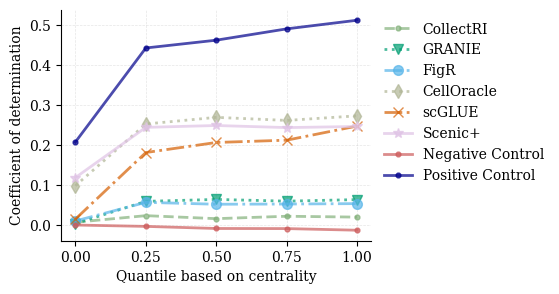

In [34]:
thetas_experiment = pd.read_csv(f'{results_folder}/benchmark/theta_experiment/reg1.csv', index_col=0)
thetas_experiment  = thetas_experiment.loc[ORDERED_MODELS]
def line_plot_theta(ax, results_df):
    markersize = 7
    linewidth = 2

    ax.grid(alpha=0.2, linewidth=.5, color='grey', linestyle='--')
    xs = np.linspace(0, 1, 5)
    for method, series in results_df.iterrows():        
        ax.plot(
            xs, series, label=method, color=COLORS[method], markersize=markersize,
            linestyle=LINESTYLES[method], marker=MARKERS[method], alpha=0.7, linewidth=linewidth
        )

    ax.set_xticks(xs)
    # ax.set_title(f'{surragate_names[norm_method]} ({reg_type})')
    ax.set_ylabel(r'Coefficient of determination')
    
        
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    ax.set_xlabel(r'Quantile based on centrality')
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)


fig, ax = plt.subplots(1, 1, figsize=(4, 3))

line_plot_theta(ax, thetas_experiment)
plt.savefig(f'{results_folder}/benchmark/figs/first-validation-performance-theta.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

## Reg 2

In [192]:
with open(os.path.join(resources_folder, 'prior', 'consensus-num-regulators.json'), 'r') as f:
    data = json.load(f)
gene_names_ = np.asarray(list(data.keys()), dtype=object)
n_features = {}
for theta in ['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9', '1']:
    n_features[theta] = np.asarray([data[gene_name][theta] for gene_name in gene_names_], dtype=int)
n_features_dict = {gene_name: i for i, gene_name in enumerate(gene_names_)}

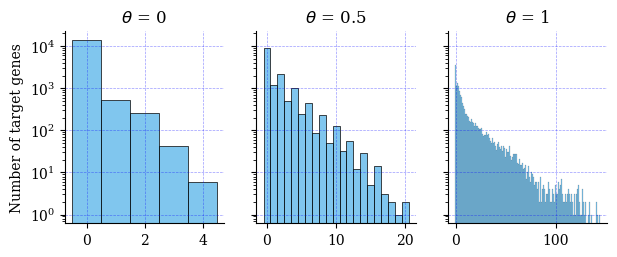

In [7]:
fig, axes = plt.subplots(1,3, figsize=(7, 2.5), sharey=True)

ax = axes[0]
seaborn.histplot(data=n_features['0'], ax=ax, discrete=True, color='#56B4E9', linewidth=.5)
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='blue')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.set_yscale('log')
# ax.set_xlabel(r'Number of selected regulators')
ax.set_ylabel('Number of target genes')
ax.set_title(r'$\theta$ = 0')

ax = axes[1]
seaborn.histplot(data=n_features['0.5'], ax=ax, discrete=True, color='#56B4E9', linewidth=.5)
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='blue')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.set_yscale('log')
# ax.set_xlabel(r'Number of selected regulators')
ax.set_ylabel('Number of target genes')
ax.set_title(r'$\theta$ = 0.5')

ax = axes[2]
seaborn.histplot(n_features['1'], ax=ax, discrete=True, color='#56B4E9')
ax.grid(alpha=0.4, linestyle='--', linewidth=0.5, color='blue')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.set_yscale('log')
# ax.set_xlabel(r'Number of selected regulators')
ax.set_ylabel('Number of target genes')
ax.set_title(r'$\theta$ = 1')

plt.savefig(f'{results_folder}/benchmark/figs/theta_reg2.png', dpi=300, transparent=True)
plt.show()

In [208]:
base_folder = os.path.join(results_folder, 'benchmark/theta_experiment/reg2/scgen_pearson/gb')
methods = ['negative_control', 'collectRI', 'FigR', 'CellOracle', 'GRANIE', 'scGLUE', 'scenicplus', 'positive_control']

data_theta = {}
for method in methods:

    series = []

    for theta in (0, 0.5, 1):
        with open(os.path.join(base_folder, str(theta), f'{method}.results.json'), 'r') as f:
            results = json.load(f)
        
        r2 = []
        for i in range(len(results['scores'])):
            gene_name = results['gene_names'][i]
            if n_features[str(theta)][n_features_dict[gene_name]] != 0:
                r2.append(results['scores'][i]['avg-r2'])

        series.append(float(np.mean(r2)))
    data_theta[method] = series 
df = pd.DataFrame(data_theta).T
df.columns = ['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']
df.to_csv('../results_folder/benchmark/default/reg2_gb.csv')

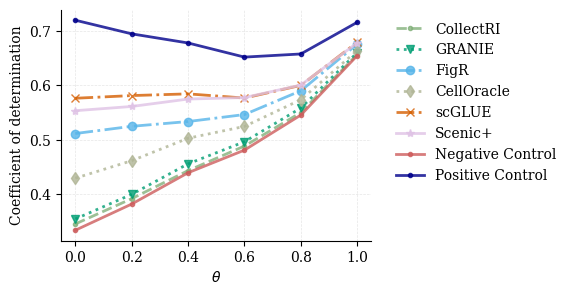

In [196]:
base_folder = os.path.join(results_folder, 'benchmark/theta_experiment/reg2/scgen_pearson/ridge')
methods = ['negative_control', 'collectRI', 'FigR', 'CellOracle', 'GRANIE', 'scGLUE', 'scenicplus', 'positive_control']
surragate_names['positive-control'] = 'Positive Control'
surragate_names['negative-control'] = 'Negative Control'
for name in ['FigR', 'GRANIE', 'scGLUE']:
    surragate_names[name] = name

fig, ax = plt.subplots(1,1 , figsize=(4, 3))

ax.grid(alpha=0.2, linewidth=.5, color='grey', linestyle='--')
xs = [0,  0.2,  0.4, 0.6, 0.8, 1]

data_theta = {}
for method in methods:

    series = []

    for theta in xs:
        with open(os.path.join(base_folder, str(theta), f'{method}.results.json'), 'r') as f:
            results = json.load(f)
        
        r2 = []
        for i in range(len(results['scores'])):
            gene_name = results['gene_names'][i]
            if n_features[str(theta)][n_features_dict[gene_name]] != 0:
                r2.append(results['scores'][i]['avg-r2'])

        series.append(float(np.mean(r2)))
    data_theta[surragate_names[method]] = series 

for method in ORDERED_MODELS:
    series = data_theta[method]
    ax.plot(
        xs, series, label=method, color=COLORS[method],
        linestyle=LINESTYLES[method], marker=MARKERS[method], alpha=.8, linewidth=2,
    )

ax.set_xticks(xs)

# ax.set_title('Ridge (APR)')
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel('Coefficient of determination')
# ax.set_ylim([0, 0.65])
plt.legend(bbox_to_anchor=(1.04, 1), loc='upper left', frameon=False)
plt.savefig(f'{results_folder}/benchmark/figs/second-validation-performance-theta.png', dpi=300, transparent=True, bbox_inches='tight')


# Reg 2, all datasets, 200 samples

In [141]:

# estimator_t = 'ridge'

# cols = ['min', 'median', 'max']

# df_grn_dict = {}
# for method in grn_models+['positive-control','negative-control']:
#     df_grn = pd.DataFrame(columns=cols)
#     for layer in datasets:
#         row = []
#         for reduction_t in cols:
#             filepath = os.path.join(RESULTS_DIR, layer, estimator_t, reduction_t, f'{method}.results.json')
#             try:
#                 with open(filepath, 'r') as f:
#                     results = json.load(f)
#             except FileNotFoundError:
#                 print(f'Cannot open "{filepath}"')
#             r2 = []
#             for i in range(len(results['scores'])):
#                 r2.append(results['scores'][i]['r2'])
#             r2 = np.asarray(r2)
#             row.append(np.mean(r2))
        
#         df_grn.loc[layer] = row
#     df_grn.columns = ['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']
#     method = method.replace('-','_')
#     df_grn_dict[method] = df_grn


# # plt.savefig('../output/benchmark/figs/second-validation-heatmap.png', dpi=300, transparent=True)

In [142]:
# fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# ax =axes[0]
# col = 'static-theta-0.0'
# scores = extract_col(df_grn_dict, col)
# headmap(scores, name=surragate_names[col], ax=ax)

# ax =axes[1]
# col = 'static-theta-0.5'
# scores_reg2_1 = extract_col(df_grn_dict, col)
# headmap(scores_reg2_1, name=surragate_names[col], ax=ax)

# ax =axes[2]
# col = 'static-theta-1.0'
# scores = extract_col(df_grn_dict, col)
# headmap(scores, name=surragate_names[col], ax=ax)

# plt.show()
# fig.savefig(f"{results_folder}/figs/benchmark_all_layers_reg2.png", dpi=300, transparent=True, bbox_inches='tight')


# All layers

In [143]:
# base_folder = '../../task_grn_benchmark/resources/results/subsample_200_gb/'

# result_file = f'{base_folder}/scores.yaml'
# with open(result_file, 'r') as file:
#     data = yaml.safe_load(file)
# dfs = {}
# for entry in data:
#     method_id = entry['method_id']
#     dataset_id = entry['dataset_id']
#     if method_id not in dfs:
#         dfs[method_id] = pd.DataFrame()
#     metrics_dict = dict(zip(entry['metric_ids'], entry['metric_values']))
#     df_entry = pd.DataFrame(metrics_dict, index=[dataset_id])
#     dfs[method_id] = pd.concat([dfs[method_id], df_entry])
# df_grn_dict = {}
# for name in grn_models:
#     # df_grn = pd.concat([dfs.get(f'reg1-{name}'), dfs.get(f'reg2-{name}')], axis=1)
#     df_grn = pd.concat([dfs.get(f'reg1-{name}')], axis=1)
#     print(name)
#     df_grn_dict[name] = df_grn
# to_save_dir = '../results_folder/benchmark/all_datasets'
# for name, df in df_grn_dict.items():
#     df_reg2 = pd.read_csv(f'{to_save_dir}/{name}.csv', index_col=0)
#     df = pd.concat([df, df_reg2], axis=1)
#     df.to_csv(f'{to_save_dir}/{name}.csv')

In [144]:
to_read_dir = '../results_folder/benchmark/all_datasets'
df_grn_dict = {}
for name in controls + grn_models:
    df = pd.read_csv(f'{to_read_dir}/{name}.csv', index_col=0)
    df_grn_dict[name] = df

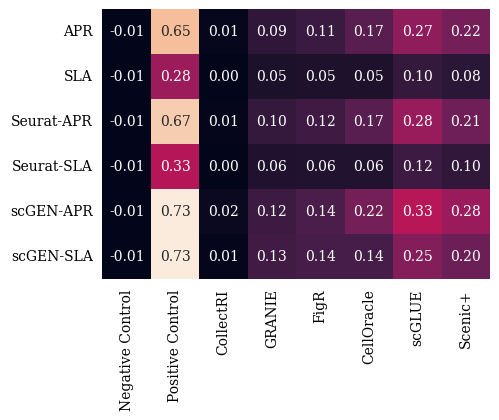

In [145]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), sharey=False)

col = 'ex(False)_tf(-1)'
scores_1_1 = extract_col(df_grn_dict, col)
headmap(scores_1_1, name='', ax=ax)

fig.savefig(f"{results_folder}/benchmark/figs/benchmark_all_layers_reg1.png", dpi=300, transparent=True, bbox_inches='tight')


In [147]:
# Reg 1
df_all = pd.concat([extract_col(df_grn_dict, col) for col in ['ex(True)_tf(-1)', 'ex(True)_tf(140)', 'ex(False)_tf(-1)', 'ex(False)_tf(140)']], axis=1)


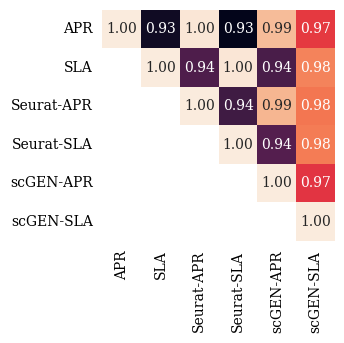

In [148]:

from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(3, 3), sharey=False)

df_corr = df_all.T.corr().round(3)

# Combine both correlation matrices to find global min and max
vmin = np.nanmin(df_corr)
vmax = np.nanmax(df_corr)

mask = np.tril(np.ones(df_corr.shape), k=-1).astype(bool)

df_corr.where(~mask, other=np.nan, inplace=True)

sns.heatmap(df_corr, ax=ax, square=False, cbar=False, annot=True, fmt='.2f', vmin=vmin, vmax=vmax)

ax.tick_params(left=False, bottom=False)
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=0)
# ax.set_title('Regression 1', pad=10)
plt.savefig(f'{results_folder}/benchmark/figs/datasets-correlation-reg1.png', dpi=300, transparent=True,  bbox_inches='tight')


In [149]:
pearsonr(df_all.iloc[0,:], df_all.iloc[4,:])

PearsonRResult(statistic=0.9911647235650765, pvalue=6.970796422897098e-28)

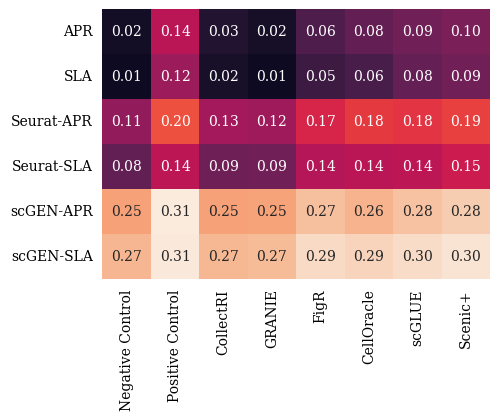

In [174]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3.5), sharey=False)

col = 'static-theta-0.5'
scores_1_1 = extract_col(df_grn_dict, col)
headmap(scores_1_1, name='', ax=ax)


fig.savefig(f"{results_folder}/benchmark/figs/benchmark_all_layers_reg2.png", dpi=300, transparent=True, bbox_inches='tight')

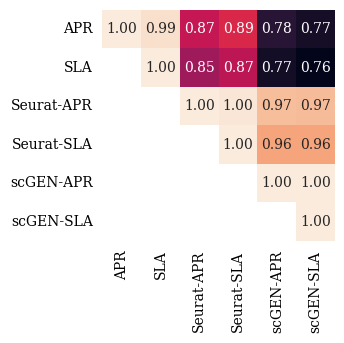

In [175]:
# Reg 2
fig, ax = plt.subplots(1, 1, figsize=(3, 3), sharey=False)
df_all = pd.concat([extract_col(df_grn_dict, col) for col in ['static-theta-0.0', 'static-theta-0.5', 'static-theta-1.0']], axis=1)

df_corr = df_all.T.corr().round(3)

# Combine both correlation matrices to find global min and max
vmin = np.nanmin(df_corr)
vmax = np.nanmax(df_corr)

mask = np.tril(np.ones(df_corr.shape), k=-1).astype(bool)

df_corr.where(~mask, other=np.nan, inplace=True)

sns.heatmap(df_corr, ax=ax, square=False, cbar=False, annot=True, fmt='.2f', vmin=vmin, vmax=vmax)

ax.tick_params(left=False, bottom=False)
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=0)
# ax.set_title('Regression 1', pad=10)
plt.savefig(f'{results_folder}/benchmark/figs/datasets-correlation-reg2.png', dpi=300, transparent=True,  bbox_inches='tight')


In [151]:
# Reg 2

layers = ['scGEN-APR', 'scGEN-SLA']

scores_reg2_0 = extract_col(df_grn_dict, col = 'static-theta-0.0')
scores_reg2_1 = extract_col(df_grn_dict, col = 'static-theta-0.5')
scores_reg2_2 = extract_col(df_grn_dict, col = 'static-theta-1.0')

df_concat = pd.concat([scores_reg2_0.loc[layers], scores_reg2_1.loc[layers], scores_reg2_2.loc[layers]], axis=1)
df_concat.T.corr().round(3)


,scGEN-APR,scGEN-SLA
scGEN-APR,1.0,1.0
scGEN-SLA,1.0,1.0


In [152]:
pearsonr(df_concat.iloc[0,:], df_concat.iloc[1,:])

PearsonRResult(statistic=0.9995143767807402, pvalue=1.2174533867600488e-34)

# One drug-cell type representation

In [212]:
def plot_r2scores_rank(scores_mat, figsize=(5, 3), fmt='.02f'):
    from matplotlib import gridspec 
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(1, 2, width_ratios=[3, 2]) 
    plt.subplots_adjust(wspace=0.1) 
    ax0 = fig.add_subplot(gs[0])
    ax1 = fig.add_subplot(gs[1])
    ax = ax0
    headmap(scores_mat, name='', ax=ax, fmt=fmt)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')

    ax = ax1
    scores_rank = scores_mat.rank(ascending=False)
    scores_rank['Mean'] = scores_rank.mean(axis=1)
    headmap_rank(scores_rank, name='', ax=ax)
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_yticks([])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')

## Reg1-GBM


In [1]:
# base_folder = '../../task_grn_benchmark/resources/results/pearson_gb_subsample/'

# result_file = f'{base_folder}/scores.yaml'
# with open(result_file, 'r') as file:
#     data = yaml.safe_load(file)
# dfs = {}
# for entry in data:
#     method_id = entry['method_id']
#     dataset_id = entry['dataset_id']
#     if method_id not in dfs:
#         dfs[method_id] = pd.DataFrame()
#     metrics_dict = dict(zip(entry['metric_ids'], entry['metric_values']))
#     df_entry = pd.DataFrame(metrics_dict, index=[dataset_id])
#     dfs[method_id] = pd.concat([dfs[method_id], df_entry])
# df_grn_dict = {}
# for name in controls + grn_models:
#     # df_grn = pd.concat([dfs.get(f'reg1-{name}'), dfs.get(f'reg2-{name}')], axis=1)
#     df_grn = pd.concat([dfs.get(f'reg1-{name}')], axis=1)
#     print(name)
#     df_grn_dict[name] = df_grn
# df_grn_dict
# to_save_dir = '../results_folder/benchmark/final'
# for name, df in df_grn_dict.items():
#     # df_reg2 = pd.read_csv(f'{to_save_dir}/reg1-{name}.csv', index_col=0)
#     # df = pd.concat([df, df_reg2], axis=1)
#     df.to_csv(f'{to_save_dir}/reg1-pearson-{name}.csv')

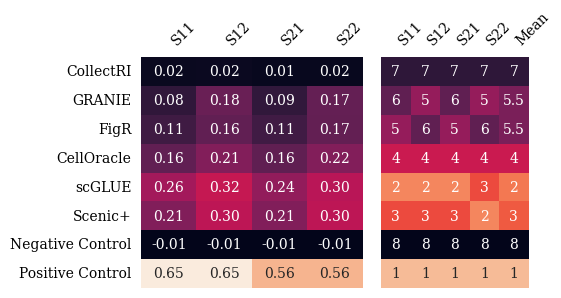

In [130]:
scores_mat = pd.read_csv(f'{results_folder}/benchmark/default/reg1_gb.csv', index_col=0)
scores_mat.drop(columns=['Mean'], inplace=True)
scores_mat.index = scores_mat.index.map(surragate_names)
scores_mat.columns = scores_mat.columns.map(surragate_names)
scores_mat = scores_mat[['S11', 'S12', 'S21', 'S22']]

plot_r2scores_rank(scores_mat)

plt.savefig(f'{results_folder}/benchmark/figs/default-reg1.png', dpi=300, transparent=True,  bbox_inches='tight')

## Reg 1-RF

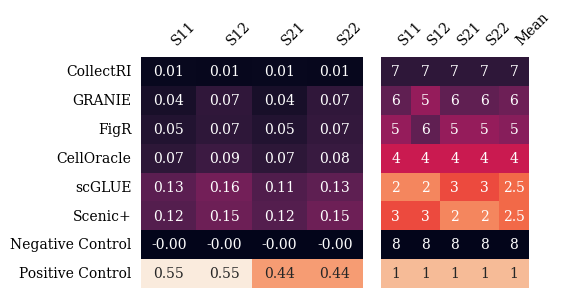

In [122]:
scores_mat = pd.read_csv(f'{results_folder}/benchmark/default/reg1_rf.csv', index_col=0)

scores_mat.drop(columns=['Mean'], inplace=True)
scores_mat.index = scores_mat.index.map(surragate_names)
scores_mat.columns = scores_mat.columns.map(surragate_names)
scores_mat = scores_mat[['S11', 'S12', 'S21', 'S22']]

plot_r2scores_rank(scores_mat)
plt.savefig(f'{results_folder}/benchmark/figs/default-reg1-rf.png', dpi=300, transparent=True,  bbox_inches='tight')

## Reg1-Ridge

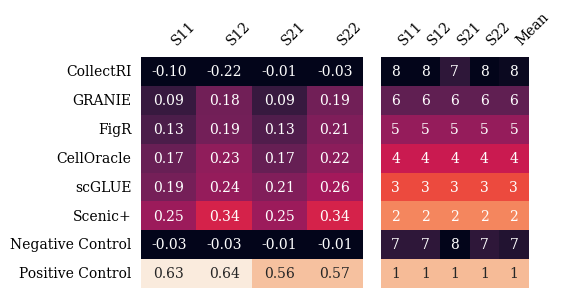

In [120]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
scores_mat = pd.read_csv(f'{results_folder}/benchmark/default/reg1_ridge.csv', index_col=0)
scores_mat.drop(columns=['Mean'], inplace=True)
scores_mat.index = scores_mat.index.map(surragate_names)
scores_mat.columns = scores_mat.columns.map(surragate_names)
scores_mat = scores_mat[['S11', 'S12', 'S21', 'S22']]


plot_r2scores_rank(scores_mat)
plt.savefig(f'{results_folder}/benchmark/figs/default-reg1-ridge.png', dpi=300, transparent=True,  bbox_inches='tight')

## reg 2-GBM

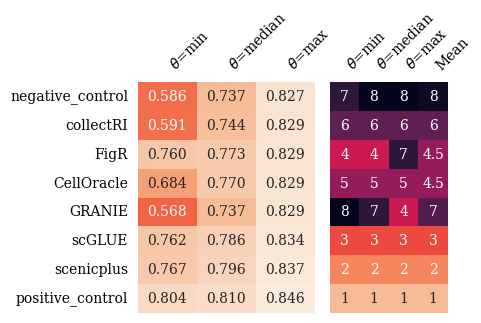

In [213]:
scores_mat = pd.read_csv(f'{results_folder}/benchmark/default/reg2_gb.csv', index_col=0)
# scores_mat.index = scores_mat.index.map(surragate_names)
scores_mat.columns = scores_mat.columns.map(surragate_names)
plot_r2scores_rank(scores_mat, figsize=(4,3), fmt='0.03f')

# plt.savefig(f'{results_folder}/benchmark/figs/default-reg2.png', dpi=300, transparent=True,  bbox_inches='tight')

## Reg 2: ridge

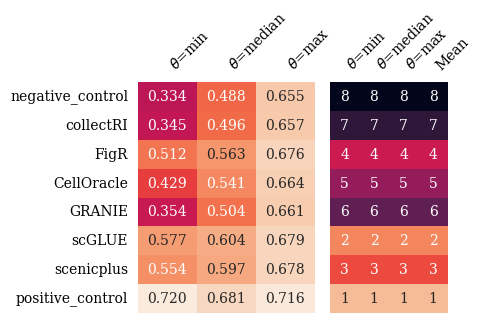

In [216]:
scores_mat = pd.read_csv(f'{results_folder}/benchmark/default/reg2_ridge.csv', index_col=0)
# scores_mat.index = scores_mat.index.map(surragate_names)
scores_mat.columns = scores_mat.columns.map(surragate_names)
plot_r2scores_rank(scores_mat, figsize=(4,3), fmt='0.03f')

# plt.savefig(f'{results_folder}/benchmark/figs/default-reg2-ridge.png', dpi=300, transparent=True,  bbox_inches='tight')

# Robustness analysis

In [ ]:

def extract_data(data, reg='reg1'):
    df_reg = pd.DataFrame({}, columns=grn_models)
    # Iterate over the data
    for entry in data:
        method_id = entry['method_id']
        reg_type, degree, method = method_id.split('-')
        if reg == 'reg1':
            col = 'ex(True)_tf(-1)'
        elif reg == 'reg2':
            col = 'static-theta-0.5'
        ex_true_tf_idx = entry['metric_ids'].index(col)
        ex_true_tf_value = entry['metric_values'][ex_true_tf_idx]
        df_reg.loc[int(degree), method] = ex_true_tf_value
    return df_reg

In [43]:
figsize=(3.5, 3)

### TF-gene links

In [64]:
base_folder = '../../task_grn_benchmark/resources/results/robust_analy_reg2_net'

result_file = f'{base_folder}/scores.yaml'
with open(result_file, 'r') as file:
    data = yaml.safe_load(file)


In [78]:
df_reg = extract_data(data, reg='reg2')
df_reg = df_reg.sort_index()
df_reg.to_csv('../results_folder/robust_analysis/reg2_net.csv')

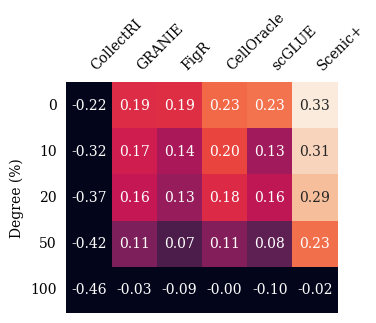

In [84]:
df_reg = pd.read_csv('../results_folder/robust_analysis/reg1_net.csv', index_col=0)
fmt = '.02f'
fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=True)
df_reg.columns = df_reg.columns.map(surragate_names)

headmap(df_reg, name='', ax=ax, fmt=fmt)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

ax.set_ylabel('Degree (%)')

plt.savefig(f'{results_folder}/benchmark/figs/robust_analys_reg1_net.png', dpi=300, transparent=True,  bbox_inches='tight')

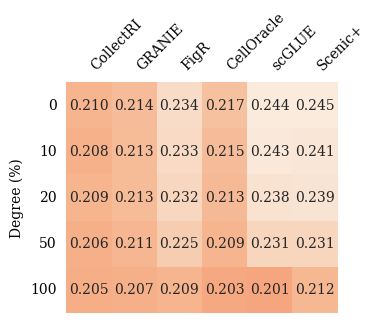

In [85]:
df_reg = pd.read_csv('../results_folder/robust_analysis/reg2_net.csv', index_col=0)
fmt = '.03f'
fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=True)
df_reg.columns = df_reg.columns.map(surragate_names)

headmap(df_reg, name='', ax=ax, fmt=fmt)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

ax.set_ylabel('Degree (%)')

plt.savefig(f'{results_folder}/benchmark/figs/robust_analys_reg2_net.png', dpi=300, transparent=True,  bbox_inches='tight')

### Weight

In [86]:
base_folder = '../../task_grn_benchmark/resources/results/robust_analy_reg2_weight'

result_file = f'{base_folder}/scores.yaml'
with open(result_file, 'r') as file:
    data = yaml.safe_load(file)

df_reg = extract_data(data, reg='reg2')
df_reg = df_reg.sort_index()
df_reg.to_csv('../results_folder/robust_analysis/reg2_weight.csv')

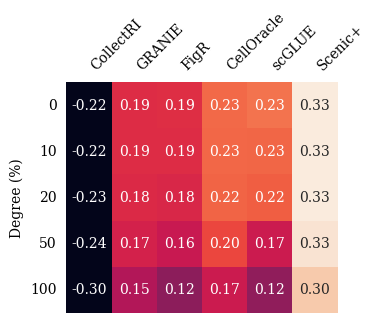

In [47]:
df_reg1 = pd.read_csv('../results_folder/robust_analysis/reg1_weight.csv', index_col=0)
fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=True)
df_reg1.columns = df_reg1.columns.map(surragate_names)

headmap(df_reg1, name='', ax=ax, fmt='.02f')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

ax.set_ylabel('Degree (%)')

plt.savefig(f'{results_folder}/benchmark/figs/robust_analys_weight.png', dpi=300, transparent=True,  bbox_inches='tight')

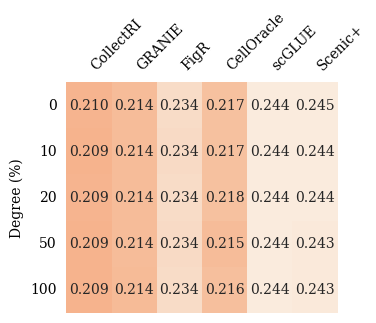

In [88]:
df_reg = pd.read_csv('../results_folder/robust_analysis/reg2_weight.csv', index_col=0)
fmt='.03f'
fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=True)
df_reg.columns = df_reg.columns.map(surragate_names)

headmap(df_reg, name='', ax=ax, fmt=fmt)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

ax.set_ylabel('Degree (%)')

plt.savefig(f'{results_folder}/benchmark/figs/robust_analys_reg2_weight.png', dpi=300, transparent=True,  bbox_inches='tight')

### Reg sign

In [90]:
base_folder = '../../task_grn_benchmark/resources/results/robust_analy_reg2_sign'

result_file = f'{base_folder}/scores.yaml'
with open(result_file, 'r') as file:
    data = yaml.safe_load(file)

df_reg = extract_data(data, reg='reg2')
df_reg = df_reg.sort_index()
df_reg.to_csv('../results_folder/robust_analysis/reg2_sign.csv')

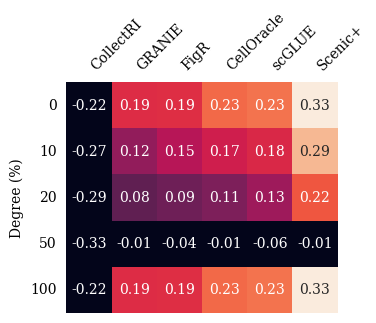

In [49]:
df_reg1 = pd.read_csv('../results_folder/robust_analysis/reg1_sign.csv', index_col=0)

fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=True)
df_reg1.columns = df_reg1.columns.map(surragate_names)

headmap(df_reg1, name='', ax=ax, fmt='.02f')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

ax.set_ylabel('Degree (%)')

plt.savefig(f'{results_folder}/benchmark/figs/robust_analys_sign.png', dpi=300, transparent=True,  bbox_inches='tight')

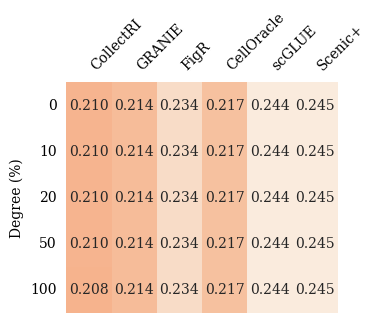

In [92]:
df_reg = pd.read_csv('../results_folder/robust_analysis/reg2_sign.csv', index_col=0)
fmt='.03f'
fig, ax = plt.subplots(1, 1, figsize=figsize, sharey=True)
df_reg.columns = df_reg.columns.map(surragate_names)

headmap(df_reg, name='', ax=ax, fmt=fmt)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

ax.set_ylabel('Degree (%)')

plt.savefig(f'{results_folder}/benchmark/figs/robust_analys_reg2_sign.png', dpi=300, transparent=True,  bbox_inches='tight')

## Perturbation effects

In [101]:

base_folder = '../../task_grn_benchmark/output/robust_analy_pc_vs_nc'

result_file = f'{base_folder}/scores.yaml'
with open(result_file, 'r') as file:
    data = yaml.safe_load(file)
df_reg1 = pd.DataFrame({}, columns=grn_models)
# Iterate over the data
for entry in data:
    method_id = entry['method_id']
    reg_type, rest = method_id.split('--')
    subsample, method = rest.split('-')
    if reg_type == 'reg1':
        col = 'ex(True)_tf(-1)'
        ex_true_tf_idx = entry['metric_ids'].index(col)
        ex_true_tf_value = entry['metric_values'][ex_true_tf_idx]
        df_reg1.loc[int(subsample), method] = ex_true_tf_value

df_reg1 = df_reg1.sort_index()
df_reg1.index = ['Default', 'NC compound', 'PC compounds']
df_reg1.to_csv('../results_folder/robust_analysis/reg1_pc_vs_ng.csv')


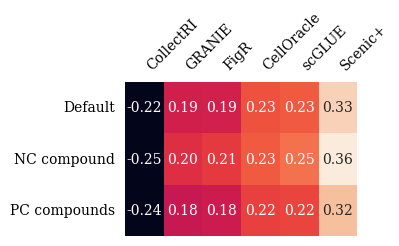

In [102]:
df_reg1 = pd.read_csv('../results_folder/robust_analysis/reg1_pc_vs_ng.csv', index_col=0)

fig, ax = plt.subplots(1, 1, figsize=(3, 2), sharey=True)
df_reg1.columns = df_reg1.columns.map(surragate_names)

headmap(df_reg1, name='', ax=ax, fmt='.02f')
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

# ax.set_ylabel('Degree (%)')

plt.savefig(f'{results_folder}/benchmark/figs/robust_analys_subsample.png', dpi=300, transparent=True,  bbox_inches='tight')

In [ ]:
df_reg1 = pd.read_csv('../results_folder/robust_analysis/reg2_pc_vs_ng.csv', index_col=0)

fmt='.03f'

fig, ax = plt.subplots(1, 1, figsize=(3, 2), sharey=True)
df_reg1.columns = df_reg1.columns.map(surragate_names)

headmap(df_reg1, name='', ax=ax, fmt=fmt)
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

# ax.set_ylabel('Degree (%)')

plt.savefig(f'{results_folder}/benchmark/figs/robust_analys_subsample.png', dpi=300, transparent=True,  bbox_inches='tight')

## causal

In [327]:
import yaml
import pandas as pd

base_folder = '../../task_grn_benchmark/resources/results/robust_analy_causal'

result_file = f'{base_folder}/scores.yaml'
with open(result_file, 'r') as file:
    data = yaml.safe_load(file)

extract_data(data, reg='reg1')

,ex(False)_tf(-1),ex(True)_tf(-1),Mean
corr,0.160433,0.168758,0.164596
corr,0.191852,0.202196,0.197024
corr,0.202665,0.213507,0.208086
corr,0.166490,0.175233,0.170861
corr,0.222673,0.234688,0.228680
corr,0.182540,0.192268,0.187404
corr,0.186710,0.196692,0.191701
corr,0.217203,0.229086,0.223144
corr,0.238084,0.250973,0.244528
corr,0.178851,0.187996,0.183423


# Resources

## Celloracle

In [234]:
cols = ['%cpu', 'peak_rss', 'rchar', 'wchar', 'duration']
cols_names = ['%CPU', 'Peak memory', 'Disk read', 'Disk write', 'Duration']

In [235]:
def convert_duration_to_seconds(duration_str):
    import re
    hours, minutes, seconds = 0, 0, 0
    time_parts = re.findall(r'(\d+)([hms])', duration_str)
    for value, unit in time_parts:
        if unit == 'h':
            hours = int(value)
        elif unit == 'm':
            minutes = int(value)
        elif unit == 's':
            seconds = int(value)
    return hours * 3600 + minutes * 60 + seconds
def convert_gb_to_bytes(gb_str):
    gb_value = float(gb_str.split()[0])
    return gb_value * 1024**3  # 1 GB = 1,073,741,824 bytes

In [281]:
# # celloracle
# base_dir = '../../task_grn_benchmark/' 
# df = pd.read_csv(f'{base_dir}/resources/results/infer/celloracle/trace.txt', sep='\t')[cols]
# df = df.drop(1)
# for col in cols:
#     if col=='%cpu':
#         df[col] = df[col].str.replace('%', '').astype(float)
#     elif col=='duration':
#         df[col] = df[col].apply(convert_duration_to_seconds)
#     else:
#         df[col] = df[col].apply(convert_gb_to_bytes)

# df.columns = cols_names

# df.index = ['celloracle']
# df.to_csv('../results_folder/resources/celloracle.csv')

In [274]:
base_dir = '../../task_grn_benchmark/' 
df = pd.read_csv(f'{base_dir}/resources/results/single_omics_all/trace.txt', sep='\t')
df = df[df.exit==0]
for col in cols:
    if col=='%cpu':
        df[col] = df[col].str.replace('%', '').astype(float)
    elif col=='duration':
        df[col] = df[col].apply(convert_duration_to_seconds)
    else:
        df[col] = df[col].apply(convert_gb_to_bytes)

# df.columns = cols_names
df_all = pd.DataFrame()
for method in ['genie3', 'grnboost2', 'ppcor', 'portia']:
    # only one method
    df_filtered = df[df['name'].str.contains(method, case=False, na=False)]
    # only the relevant row
    df_filtered = df_filtered.iloc[[df_filtered.duration.argmax()]]
    df_filtered.index = [method]
    df_all = pd.concat([df_all, df_filtered], axis=0)
df_all = df_all[cols]
df_all.columns = cols_names
df_all

,%CPU,Peak memory,Disk read,Disk write,Duration
genie3,3173.8,3.758096e+10,7.286412e+11,1.565516e+11,36844
grnboost2,2250.1,3.543348e+09,4.333622e+11,1.825361e+09,5314
ppcor,100.7,1.492501e+10,3.890167e+11,1.932735e+09,1564
portia,109.5,1.299228e+10,3.886945e+11,2.040109e+09,3134


In [280]:
df_all.to_csv('../results_folder/resources/all.csv')

# Single omics grns

In [294]:
import yaml
import pandas as pd
base_folder = '../../task_grn_benchmark/resources/results/grn_evaluation_so_ridge/'

result_file = f'{base_folder}/scores.yaml'
with open(result_file, 'r') as file:
    data = yaml.safe_load(file)


df_reg1 = extract_data(data, reg='reg1', dataset_id='pearson')
df_reg2 = extract_data(data, reg='reg2', dataset_id='scgen_pearson')
df_reg1.to_csv('../results_folder/benchmark/default/reg1_ridge_so.csv')
df_reg2.to_csv('../results_folder/benchmark/default/reg2_ridge_so.csv')
    

In [295]:

# fig, axes = plt.subplots(1, 2 , figsize=(6,3), sharey=True)
# # scores_mat.index = scores_mat.index.map(surragate_names)
# # scores_mat.columns = scores_mat.columns.map(surragate_names)
# # scores_mat = scores_mat[['S11', 'S12']]
# scores_mat['Mean'] = scores_mat.mean(axis=1)
# ax = axes[0]
# headmap(scores_mat, name='', ax=ax)
# ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')

# ax = axes[1]
# scores_rank = scores_mat.rank(ascending=False)
# scores_rank['Mean'] = scores_rank.mean(axis=1)
# headmap_rank(scores_rank, name='', ax=ax)
# ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='left')
# # plt.savefig(f'{results_folder}/benchmark/figs/final-reg1.png', dpi=300, transparent=True,  bbox_inches='tight')

# Overal scores and figure


In [320]:
# r2 scores
multi_reg1 = pd.read_csv('../results_folder/benchmark/default/reg1_ridge.csv', index_col=0)[['ex(False)_tf(-1)', 'ex(True)_tf(-1)']]
multi_reg2 = pd.read_csv('../results_folder/benchmark/default/reg2_ridge.csv', index_col=0)[['static-theta-0.0', 'static-theta-0.5']]
if 'Mean' in multi_reg2:
    multi_reg2.drop(columns='Mean', inplace=True)
multi_scores = pd.concat([multi_reg1, multi_reg2], axis=1)
so_reg1 = pd.read_csv('../results_folder/benchmark/default/reg1_ridge_so.csv', index_col=0)
if 'Mean' in so_reg1:
    so_reg1.drop(columns='Mean', inplace=True)
so_reg2 = pd.read_csv('../results_folder/benchmark/default/reg2_ridge_so.csv', index_col=0)
if 'Mean' in so_reg2:
    so_reg2.drop(columns='Mean', inplace=True)
so_scores = pd.concat([so_reg1, so_reg2], axis=1)

df_scores = pd.concat([multi_scores, so_scores], axis=0)
df_scores[df_scores<0] = 0
min_col = df_scores.min(axis=0)
max_col = df_scores.max(axis=0)
df_scores = (df_scores-min_col)/(max_col-min_col)
# df_scores.columns = df_scores.columns.map(surragate_names)
df_scores['overall_score'] = df_scores.mean(axis=1)
df_scores

,ex(False)_tf(-1),ex(True)_tf(-1),static-theta-0.0,static-theta-0.5,overall_score
collectri,0.000000,0.000000,0.029924,0.044208,0.018533
granie,0.147828,0.290600,0.053549,0.085647,0.144406
figr,0.197500,0.295371,0.460473,0.389906,0.335812
celloracle,0.270169,0.360036,0.247804,0.277545,0.288889
scglue,0.298297,0.371170,0.628442,0.601405,0.474829
scenicplus,0.389616,0.527432,0.569186,0.562574,0.512202
negative_control,0.000000,0.000000,0.000000,0.000000,0.000000
positive_control,1.000000,1.000000,1.000000,1.000000,1.000000
ppcor,0.041831,0.027796,0.207245,0.182460,0.114833
genie3,0.271378,0.504087,0.625895,0.469227,0.467647


In [314]:
# resources
df_resources = pd.read_csv('../results_folder/resources/all.csv', index_col=0) 
df_resources


,%CPU,Peak memory,Disk read,Disk write,Duration
genie3,3173.8,3.758096e+10,7.286412e+11,1.565516e+11,36844
grnboost2,2250.1,3.543348e+09,4.333622e+11,1.825361e+09,5314
ppcor,100.7,1.492501e+10,3.890167e+11,1.932735e+09,1564
portia,109.5,1.299228e+10,3.886945e+11,2.040109e+09,3134
celloracle,332.8,3.639985e+10,5.604932e+10,2.880849e+11,14706


In [321]:
df_all = pd.concat([df_scores, df_resources], axis=1)
df_all.index = df_all.index.map(surragate_names)
df_all = df_all.fillna(0)

df_all.index.name = 'method_name' 
df_all['mean_cpu_pct_scaled'] = df_all['%CPU']/df_all['%CPU'].max()
df_all['mean_peak_memory_log_scaled'] = np.log(df_all['Peak memory'])
df_all['mean_peak_memory_str'] =  [f"{int(value/ 1E9)}" for value in df_all['Peak memory']]
df_all["mean_disk_read_log_scaled"] = np.log(df_all['Disk read'])
df_all["mean_disk_read_str"] = [f"{int(value/ 1E9)}" for value in df_all['Disk read']]
df_all["mean_disk_write_log_scaled"] = np.log(df_all['Disk write'])
df_all["mean_disk_write_str"] =  [f"{int(value/ 1E9)}" for value in df_all['Disk write']]
df_all["mean_duration_log_scaled"] = np.log(df_all['Duration'])
df_all["mean_duration_str"] = [f"{int(value/ (60*60))}" for value in df_all['Duration']]

df_all = df_all.reset_index()
df_all.to_csv(summary_all_file, sep='\t')

!Rscript ../src/metrics_figure.R ../results_folder/benchmark/summary_all.tsv ../results_folder/benchmark/figure.pdf


/root/anaconda3/envs/py10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/anaconda3/envs/py10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/anaconda3/envs/py10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/root/anaconda3/envs/py10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
`thisfile()` was deprecated in rprojroot 2.0.0.
ℹ Please use `whereami::thisfile()` instead. 
New names:
• `` -> `...1`
Rows: 12 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): method_name
dbl (20): ...1, ex(False)_tf(-1), ex(True)_tf(-1), static-theta-0.0, static-...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_ty